In [1]:
# IPython magic to import matplotlib and plot inline
%matplotlib inline

In [2]:
# Path settings
import os
# we use a relative path here, you can also specify an absolute path for your system
out_path = "output/05_hyperelasticity_neohook_p-u"
os.makedirs(out_path, exist_ok=True)

import fenics as fe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt 

fe.parameters["form_compiler"]["representation"] = "uflacs"
fe.parameters["form_compiler"]["quadrature_degree"] = 2

In [3]:
def get_tensor_components(tensor, point, name=None):
    index_2d = {   'xx' : 0, 'xy' : 1,
                   'yx' : 2, 'yy' : 3}
    index_3d = {   'xx' : 0, 'xy' : 1, 'xz' : 2,
                   'yx' : 3, 'yy' : 4, 'yz' : 5,
                   'zx' : 6, 'zy' : 7, 'zz' : 8}
    tensor_at_point = tensor(point)
    if len(tensor_at_point)==4:
        name_val_dict = { key : tensor_at_point[index] for key, index in index_2d.items()}
    elif len(tensor_at_point)==9:
        name_val_dict = { key : tensor_at_point[index] for key, index in index_3d.items()}
    else:
        print("Tensor at has %i elements -- can't handle"%len(tensor_at_point))
        name_val_dict = {}
    if name:
        name_val_dict = { "%s_%s"%(name, key) : val for key, val in name_val_dict.items()}
    return name_val_dict
        

In [4]:
# mesh

length_x = 1.0
length_y = 1.0
length_z = 1.0
n_elements = 10
#mesh = fe.RectangleMesh(fe.Point(0,0), fe.Point(length_x,length_y), 100,100)
mesh = fe.BoxMesh(fe.Point(0,0,0),fe.Point(length_x, length_y, length_z),n_elements, n_elements, n_elements)


In [5]:
# Mark sides
sides_x_1  = fe.CompiledSubDomain("near(x[0], side) && on_boundary", side = 0)
sides_x_2  = fe.CompiledSubDomain("near(x[0], side) && on_boundary", side = 1)
sides_y_1  = fe.CompiledSubDomain("near(x[1], side) && on_boundary", side = 0)
sides_y_2  = fe.CompiledSubDomain("near(x[1], side) && on_boundary", side = 1)
sides_z_1  = fe.CompiledSubDomain("near(x[2], side) && on_boundary", side = 0)
sides_z_2  = fe.CompiledSubDomain("near(x[2], side) && on_boundary", side = 1)

sides = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
sides.set_all(0)
sides_x_1.mark(sides, 0)
sides_x_2.mark(sides, 1)
sides_y_1.mark(sides, 2)
sides_y_2.mark(sides, 3)
sides_z_1.mark(sides, 4)
sides_z_2.mark(sides, 5)

#-- save boundary to vtu for inspection
boundary_file = fe.File(os.path.join(out_path, "sides.pvd"))
boundary_file << sides

In [6]:
displacement_element = fe.VectorElement("Lagrange", mesh.ufl_cell(), 2)
pressure_element = fe.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
element = fe.MixedElement([displacement_element, pressure_element])

V = fe.FunctionSpace(mesh, element)

# FunctionSpace
dup = fe.TrialFunction(V)
vq  = fe.TestFunction(V)
up    = fe.Function(V)
u, p  = fe.split(up)
# u.rename("displacement[mm]", "")

In [7]:
ele = V.sub(0).element()
print(ele.signature())
cell = next(fe.cells(mesh))
ele.tabulate_dof_coordinates(cell)

VectorElement(FiniteElement('Lagrange', tetrahedron, 2), dim=3)


array([[0.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.  ],
       [0.1 , 0.  , 0.1 ],
       [0.1 , 0.1 , 0.1 ],
       [0.1 , 0.05, 0.1 ],
       [0.1 , 0.05, 0.05],
       [0.1 , 0.  , 0.05],
       [0.05, 0.05, 0.05],
       [0.05, 0.  , 0.05],
       [0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.  ],
       [0.1 , 0.  , 0.1 ],
       [0.1 , 0.1 , 0.1 ],
       [0.1 , 0.05, 0.1 ],
       [0.1 , 0.05, 0.05],
       [0.1 , 0.  , 0.05],
       [0.05, 0.05, 0.05],
       [0.05, 0.  , 0.05],
       [0.05, 0.  , 0.  ],
       [0.  , 0.  , 0.  ],
       [0.1 , 0.  , 0.  ],
       [0.1 , 0.  , 0.1 ],
       [0.1 , 0.1 , 0.1 ],
       [0.1 , 0.05, 0.1 ],
       [0.1 , 0.05, 0.05],
       [0.1 , 0.  , 0.05],
       [0.05, 0.05, 0.05],
       [0.05, 0.  , 0.05],
       [0.05, 0.  , 0.  ]])

In [8]:
# Mark boundary subdomians
bcl = fe.DirichletBC(V.sub(0).sub(0), 0, sides_x_1)
bc_right_expr = fe.Expression(("d"), d=0.0, element=V.sub(0).ufl_element())
bcr = fe.DirichletBC(V.sub(0).sub(0), bc_right_expr, sides_x_2)

bc_sides_y = fe.DirichletBC(V.sub(0).sub(1), 0, sides_y_1)
bc_sides_z = fe.DirichletBC(V.sub(0).sub(2), 0, sides_z_1)

bcs = [bcl, bcr, bc_sides_y, bc_sides_z]

In [9]:
# Functions for 

def defGrad(u):
    """
    Compute deformation gradient from displacements
    """
    d = u.geometric_dimension()
    I = fe.Identity(d)
    F = I + fe.grad(u)             
    return F




def strainEnergyDensity_1(F, p, mu, lmbda):
    J = fe.det(F)
    C = F.T*F      # Right Cauchy-Green tensor
    I1 = fe.tr(C)  # Invariants 
    #return (mu/2.)*(I1 - 3.) - (mu + p)*fe.ln(J) - lmbda/2.*p*p
    #return (mu/2.)*(I1 - 3.) - p*fe.ln(J)
    return (mu/2.)*(I1 - 3.) - p*(1-J) 

def strainEnergyDensity_2(F, p, mu, lmbda):
    """  
    in this formulation, the lagrange multiplier p correseponds to the pressure p= 1/3 tr(S)
    """
    J = fe.det(F)
    C = F.T*F      # Right Cauchy-Green tensor
    C_ = J**(-2./3.)*C
    I1 = fe.tr(C_)  # Invariants 
    return (mu/2.)*(I1 - 3.) - p*(1-J)

def strainEnergyDensity_3(F, p, mu, lmbda):
    """equivalent to strainEnergyDensity_2"""
    J = fe.det(F)
    C = F.T*F      
    I1 = fe.tr(C)   
    return (mu/2.)*(I1 - 3.) - p*(1-J) + mu/2. * I1 * (J**(-2./3.) - 1)


def strainEnergyDensity_4(F, p, mu, lmbda):
    J = fe.det(F)
    C = F.T*F      # Right Cauchy-Green tensor
    I1 = fe.tr(C)  # Invariants 
    return (mu/2.)*(I1 - 3.) - (mu + p)*fe.ln(J) - lmbda/2.*p*p


def strainEnergyDensity_5(F, p, mu, lmbda):
    J = fe.det(F)
    C = F.T*F      # Right Cauchy-Green tensor
    I1 = fe.tr(C)  # Invariants 
    return (mu/2.)*(I1 - 3.) - p*fe.ln(J)

strainEnergyDensityFunctionNeoHookean = strainEnergyDensity_2
    
formulation_name = "strainEnergyDensity_2"

out_path = os.path.join(out_path, formulation_name)
os.makedirs(out_path, exist_ok=True)


In [10]:
Ey = 1000E-6
nu= 0.4999999999999

mu    = Ey / (2.*(1+nu))
lmbda = Ey*nu / ((1+nu)*(1-2*nu))
print(mu, lmbda)

0.00033333333333335555 1667073709.9277794


In [11]:
# create deformation gradient
F = defGrad(u)

F = fe.variable(F) # !!! needed to be able to differentiate strain energydensity function wrt F for stress computation

# instantiate strain energy density function for given material properties

psi = strainEnergyDensityFunctionNeoHookean(F=F, p=p, mu=mu, lmbda=lmbda)

# total potential energy 
Pi = psi * fe.dx 

# Compute 1st variation of Pi (directional derivative about u in dir. of v)
Fpi = fe.derivative(Pi, up, vq)

# Compute Jacobian of F
Jac = fe.derivative(Fpi, up, dup)

# du = fe.TrialFunction(V)
# Fpi = fe.derivative(Pi, u, v)
# Jac = fe.derivative(Fpi, u, du)

In [12]:
# Define the solver
problem = fe.NonlinearVariationalProblem(Fpi, up, bcs, Jac)
solver = fe.NonlinearVariationalSolver(problem)

# Set solver parameters (optional)
prm = solver.parameters
# prm['nonlinear_solver'] = 'snes'
# prm['snes_solver']['line_search'] = 'basic'
# prm['snes_solver']['linear_solver']= 'lu'

#prm['newton_solver']['linear_solver'] = 'mumps'
prm['newton_solver']['linear_solver'] = 'petsc'
#prm['newton_solver']['preconditioner'] = 't_krylov_solver_preconditioners'

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [13]:
T = fe.TensorFunctionSpace(mesh, 'P', 1)
W = fe.FunctionSpace(mesh, 'P', 1)
VU = fe.FunctionSpace(mesh, displacement_element)
VP = fe.FunctionSpace(mesh, pressure_element)



# Create XMDF file for the solution
xmdffile = fe.XDMFFile(os.path.join(out_path, formulation_name + '_results_quad-u_lin-p.xdmf'))
xmdffile.parameters["flush_output"] = True
xmdffile.parameters["functions_share_mesh"] = True

df = pd.DataFrame()

# n = up.vector().get_local().shape
# up_noise_np = np.random.rand(n[0])
# up.vector().set_local(up_noise_np)

df = pd.DataFrame()


for d in np.arange(-0.6, 2.4, 0.2):
    stretch = (length_x + d)/length_x
    print("-- solving for stretch = %.2f"%stretch)
    bc_right_expr.d = d
    %time solver.solve()
    u, p = fe.split(up)
    
    u_project = fe.project(u, VU, solver_type='cg')
    p_project = fe.project(p, VP, solver_type='cg')
    u_project.rename("displacement[mm]", "")
    p_project.rename("pressure", "")
    xmdffile.write(u_project,d)
    xmdffile.write(p_project,d)
    
    # compute stresS
    S = 1/fe.det(F)*fe.diff(psi, F)*F.T            
    S_project = fe.project(S, T, solver_type='cg')
    S_project.rename("cauchy_stress[MPa]", "")
    xmdffile.write(S_project,d)
    # project F
    F_project = fe.project(F, T, solver_type='cg')
    F_project.rename("deformation_gradient", "")
    xmdffile.write(F_project,d)
    # project C
    C_project = fe.project(F.T*F, T, solver_type='cg')
    C_project.rename("cauchy_green", "")
    xmdffile.write(C_project,d)
    # compute J
    J = fe.det(F)
    J_project = fe.project(J, W, solver_type='cg')
    J_project.rename("det(F)", "")
    xmdffile.write(J_project,d)
    
    # p from stress tensor 
    p_stress = 1./3.*fe.tr(S)
    p_stress_project = fe.project(p_stress, VP, solver_type='cg')
    p_stress_project.rename("p_from_stress", "")
    xmdffile.write(p_stress_project,d)
    
    # to table
    point = fe.Point(1, 0.5)
    s = S_project(point)
    f = F_project(point)
    c = C_project(point)
    j = J_project(point)
    U = u_project(point)
    P = p_project(point)
    P_stress = p_stress_project(point)
    df_dict = {}
    df_dict["stretch_ratio"] = stretch
    df_dict.update( get_tensor_components(S_project, point, 'S') )
    df_dict.update( get_tensor_components(F_project, point, 'F') )
    df_dict.update( get_tensor_components(C_project, point, 'C') )
    df_dict["Sxx_analytic"] = mu * (stretch*stretch - 1./stretch) # 3D, uniaxial tension, unconstrained; https://en.wikipedia.org/wiki/Neo-Hookean_solid
    df_dict["u_x"] = U[0]
    df_dict["p"] = P
    df_dict["p_from_stress"] = P_stress
    #print(df_dict)
    df = df.append(df_dict, ignore_index=True)

xmdffile.close()    
    

-- solving for stretch = 0.40
CPU times: user 1min 25s, sys: 4.65 s, total: 1min 30s
Wall time: 1min 22s
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
-- solving for stretch = 0.60
CPU times: user 1min 33s, sys: 4.12 s, total: 1min 37s
Wall time: 1min 29s
-- solving for stretch = 0.80
CPU times: user 1min 6s, sys: 3.32 s, total: 1min 9s
Wall time: 1min 3s
-- solving for stretch = 1.00
CPU times: user 1min 5s, sys: 3.08 s, total: 1min 8s
Wall time: 1min 2s
-- solving for stretch = 1.20
CPU times: user 1min 7s, sys: 3.34 s, total: 1min 11s
Wall time: 1min 4s
-- solving for stretch = 1.40
CPU times: user 1min, sys: 3.47 s, total: 1min 3s
Wall time: 57.1 s
-- solving for stretch = 1.60
CPU times: user 58.7 s, sys: 3.84 s, total: 1min 2s
Wall time: 55.4 s
-- solving for stretch = 1.80
CPU times: user 56.9 s, sys: 3.92 s, total: 1min
Wall time: 53.6 s
-- solving for stretch = 2.00
CPU times: user 57.1 s, sy

In [14]:
df["S_xx_norm"] = df["S_xx"]/mu
df["S_xy_norm"] = df["S_xy"]/mu
df["S_yx_norm"] = df["S_yx"]/mu
df["S_yy_norm"] = df["S_yy"]/mu
df["S_zz_norm"] = df["S_zz"]/mu
df["Sxx_analytic_norm"] = df["Sxx_analytic"]/mu

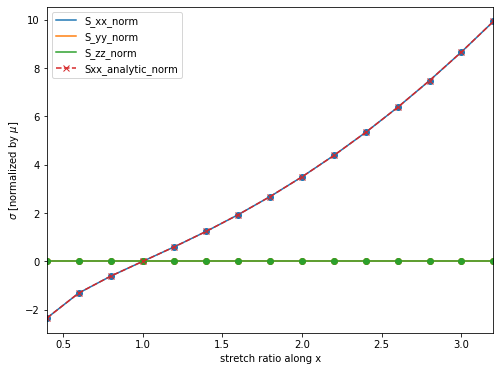

In [15]:
fig, ax = plt.subplots(figsize=(8,6))
df.plot(x="stretch_ratio", y=["S_xx_norm", "S_yy_norm", "S_zz_norm"], marker='o', ax=ax)
df.plot(x="stretch_ratio", y=["Sxx_analytic_norm"], marker='x', linestyle='--', ax=ax)
ax.set_ylabel("$\sigma$ [normalized by $\mu$]")
ax.set_xlabel("stretch ratio along x")
fig.savefig(os.path.join(out_path, formulation_name + "_stresses.png" ))
plt.show()


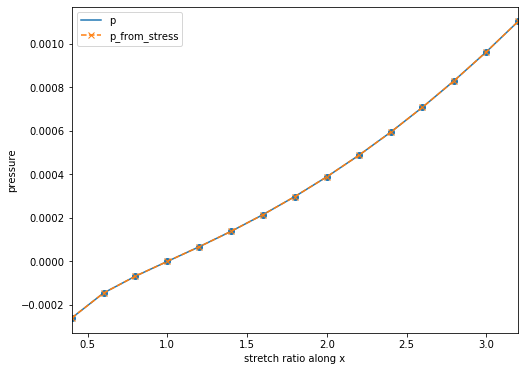

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
df.plot(x="stretch_ratio", y=["p"], marker='o', ax=ax)
df.plot(x="stretch_ratio", y=["p_from_stress"], marker='x', linestyle='--', ax=ax)
ax.set_ylabel("pressure")
ax.set_xlabel("stretch ratio along x")
fig.savefig(os.path.join(out_path, formulation_name + "_pressures.png" ))
plt.show()


In [17]:
df.columns

Index(['C_xx', 'C_xy', 'C_xz', 'C_yx', 'C_yy', 'C_yz', 'C_zx', 'C_zy', 'C_zz',
       'F_xx', 'F_xy', 'F_xz', 'F_yx', 'F_yy', 'F_yz', 'F_zx', 'F_zy', 'F_zz',
       'S_xx', 'S_xy', 'S_xz', 'S_yx', 'S_yy', 'S_yz', 'S_zx', 'S_zy', 'S_zz',
       'Sxx_analytic', 'p', 'p_from_stress', 'stretch_ratio', 'u_x',
       'S_xx_norm', 'S_xy_norm', 'S_yx_norm', 'S_yy_norm', 'S_zz_norm',
       'Sxx_analytic_norm'],
      dtype='object')

In [18]:
# -- solving for stretch = 0.40
# CPU times: user 1min 19s, sys: 4.83 s, total: 1min 24s
# Wall time: 1min 15s
# -- solving for stretch = 0.80
# CPU times: user 1min 33s, sys: 6 s, total: 1min 39s
# Wall time: 1min 27s
# -- solving for stretch = 1.20
# CPU times: user 1min 12s, sys: 5.34 s, total: 1min 18s
# Wall time: 1min 8s
# -- solving for stretch = 1.60
# CPU times: user 1min, sys: 3.93 s, total: 1min 4s
# Wall time: 56.9 s
# -- solving for stretch = 2.00
# CPU times: user 57 s, sys: 4.17 s, total: 1min 1s
# Wall time: 53.5 s
# -- solving for stretch = 2.40
# CPU times: user 56.5 s, sys: 4.2 s, total: 1min
# Wall time: 53 s
# -- solving for stretch = 2.80
# CPU times: user 57.8 s, sys: 4.26 s, total: 1min 2s
# Wall time: 54.3 s
# -- solving for stretch = 3.20
# CPU times: user 58.1 s, sys: 4.14 s, total: 1min 2s
# Wall time: 54.5 s





# -- solving for stretch = 0.40
# CPU times: user 3min 14s, sys: 2min 9s, total: 5min 23s
# Wall time: 35 s
# -- solving for stretch = 0.80
# CPU times: user 3min 49s, sys: 2min 23s, total: 6min 13s
# Wall time: 36.7 s
# -- solving for stretch = 1.20
# CPU times: user 2min 47s, sys: 1min 31s, total: 4min 19s
# Wall time: 24.8 s
# -- solving for stretch = 1.60
# CPU times: user 2min 10s, sys: 1min 12s, total: 3min 22s
# Wall time: 19.7 s
# -- solving for stretch = 2.00
# CPU times: user 2min 5s, sys: 1min 9s, total: 3min 14s
# Wall time: 18.5 s
# -- solving for stretch = 2.40
# CPU times: user 2min 2s, sys: 1min 7s, total: 3min 9s
# Wall time: 18 s
# -- solving for stretch = 2.80
# CPU times: user 2min 10s, sys: 1min 13s, total: 3min 23s
# Wall time: 20 s
# -- solving for stretch = 3.20
# CPU times: user 2min 17s, sys: 1min 23s, total: 3min 40s
# Wall time: 21.4 s



In [19]:
fe.list_linear_solver_methods()

In [20]:
fe.list_krylov_solver_preconditioners()